In [1]:
import pickle

from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import jax
import matplotlib.pyplot as plt
import numpy as np
from torusimaging_helpers.plot import (
    plot_bdata,
    plot_data_model_residual,
    plot_spline_functions,
    plot_az_Jz,
)

jax.config.update("jax_enable_x64", True)

In [21]:
name = "jason-sim"

pdata = at.QTable.read(f"../.cache/{name}-pdata.hdf5")
bdata = dict(np.load(f"../.cache/{name}-bdata.npz"))

# TODO: fix this!
if not hasattr(bdata["pos"], "unit"):
    bdata["pos"] = bdata["pos"] * u.kpc
    bdata["vel"] = bdata["vel"] * u.kpc / u.Myr

with open(f"../.cache/{name}-model.pkl", "rb") as f:
    model = pickle.load(f)

with open(f"../.cache/{name}-params-opt.pkl", "rb") as f:
    res_params = pickle.load(f)

with open(f"../.cache/{name}-mcmc-results.pkl", "rb") as f:
    mcmc_states, mcmc_params = pickle.load(f)

MAP_params = mcmc_params[mcmc_states.logdensity.argmax()]

max_z = bdata["pos"].max()
max_vz = bdata["vel"].max()

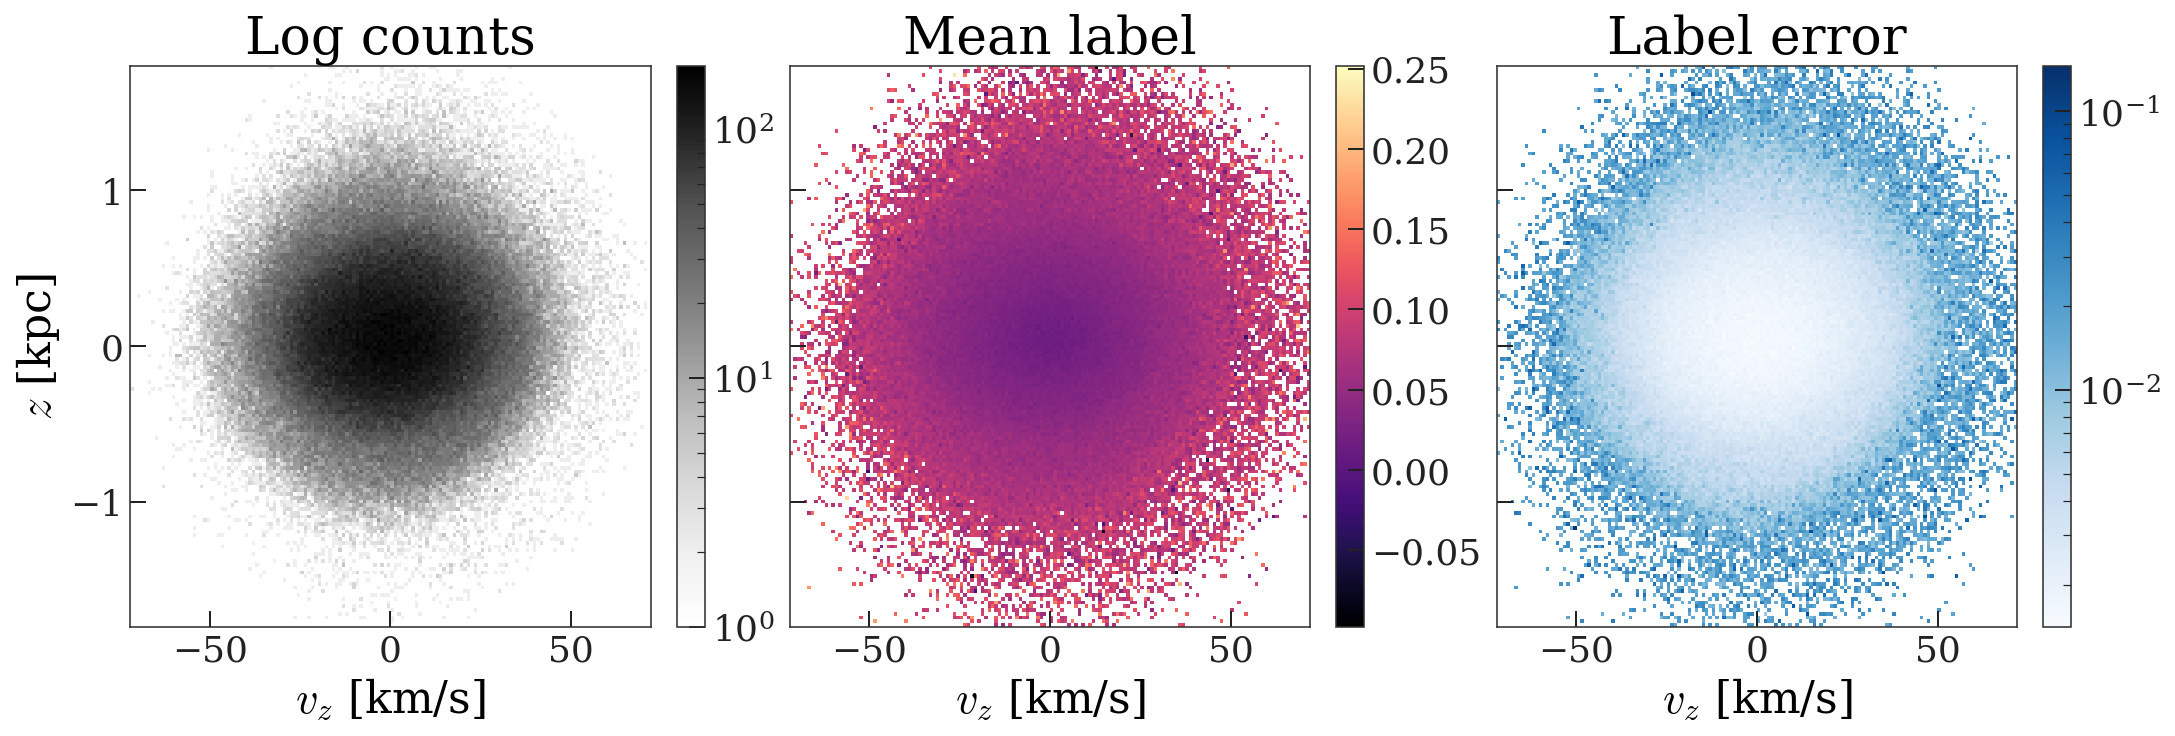

In [22]:
_ = plot_bdata(bdata)

In [23]:
bdata["pos"].max(), bdata["vel"].max()

(<Quantity 1.788 kpc>, <Quantity 0.07314437 kpc / Myr>)

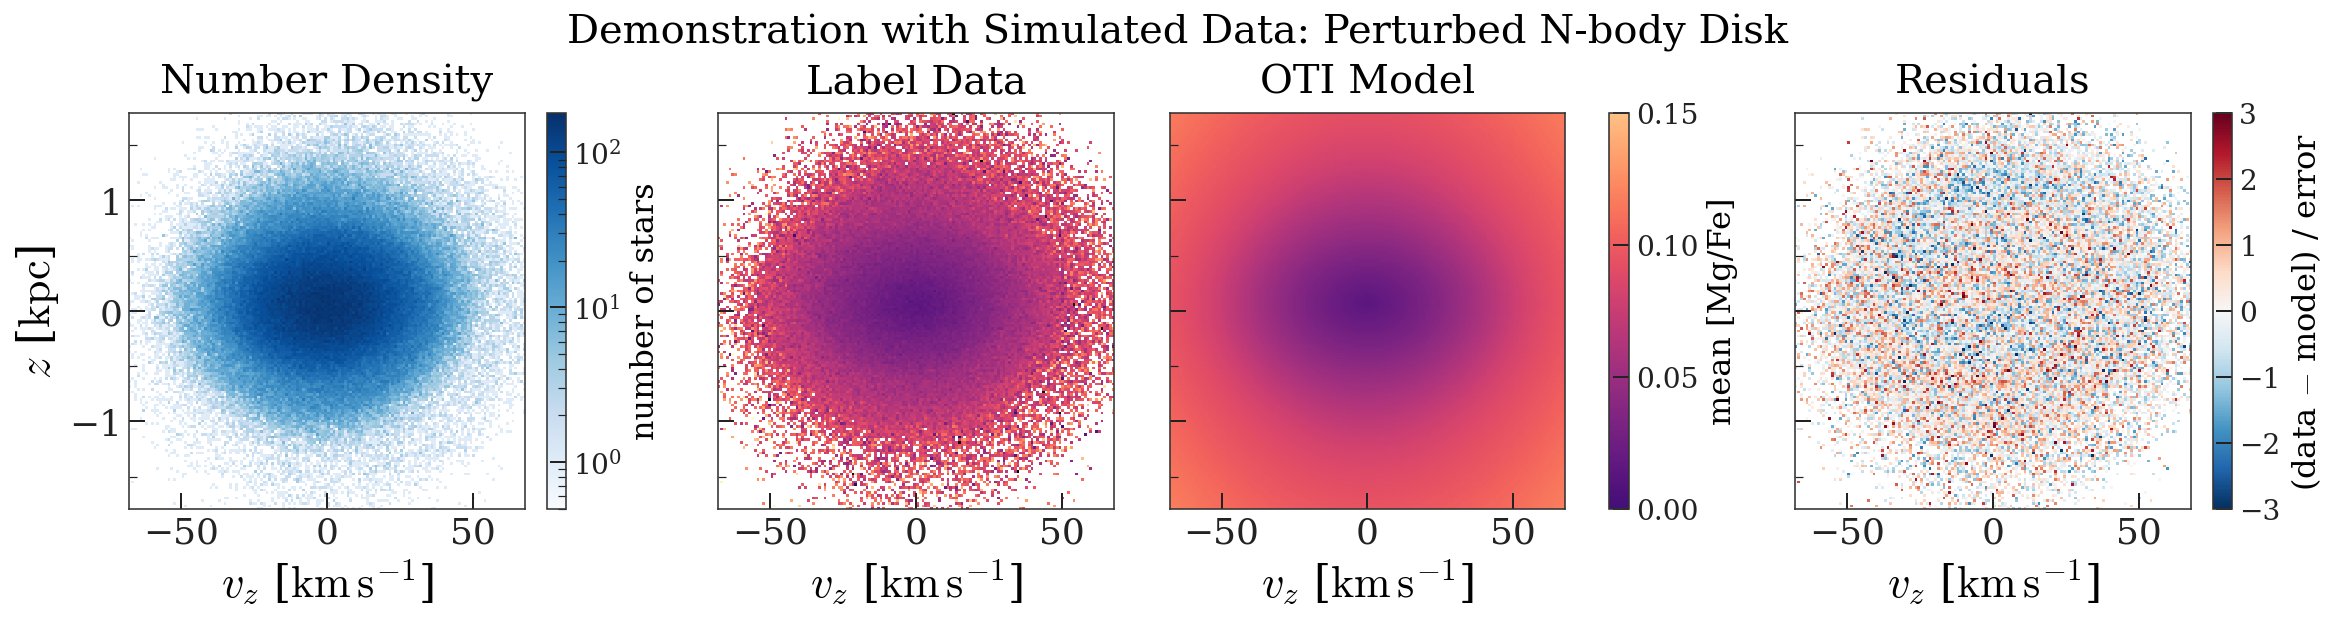

In [24]:
title = "Perturbed N-body Disk"

fig, axes = plot_data_model_residual(
    model,
    bdata,
    # res_params,
    MAP_params,
    zlim=max_z,
    suptitle2=title,
    # residual_lim=0.02
)
fig.savefig(
    f"../tex/figures/{name}-data-model.pdf",
    dpi=250,
    pad_inches=0.1,
    bbox_inches="tight",
)

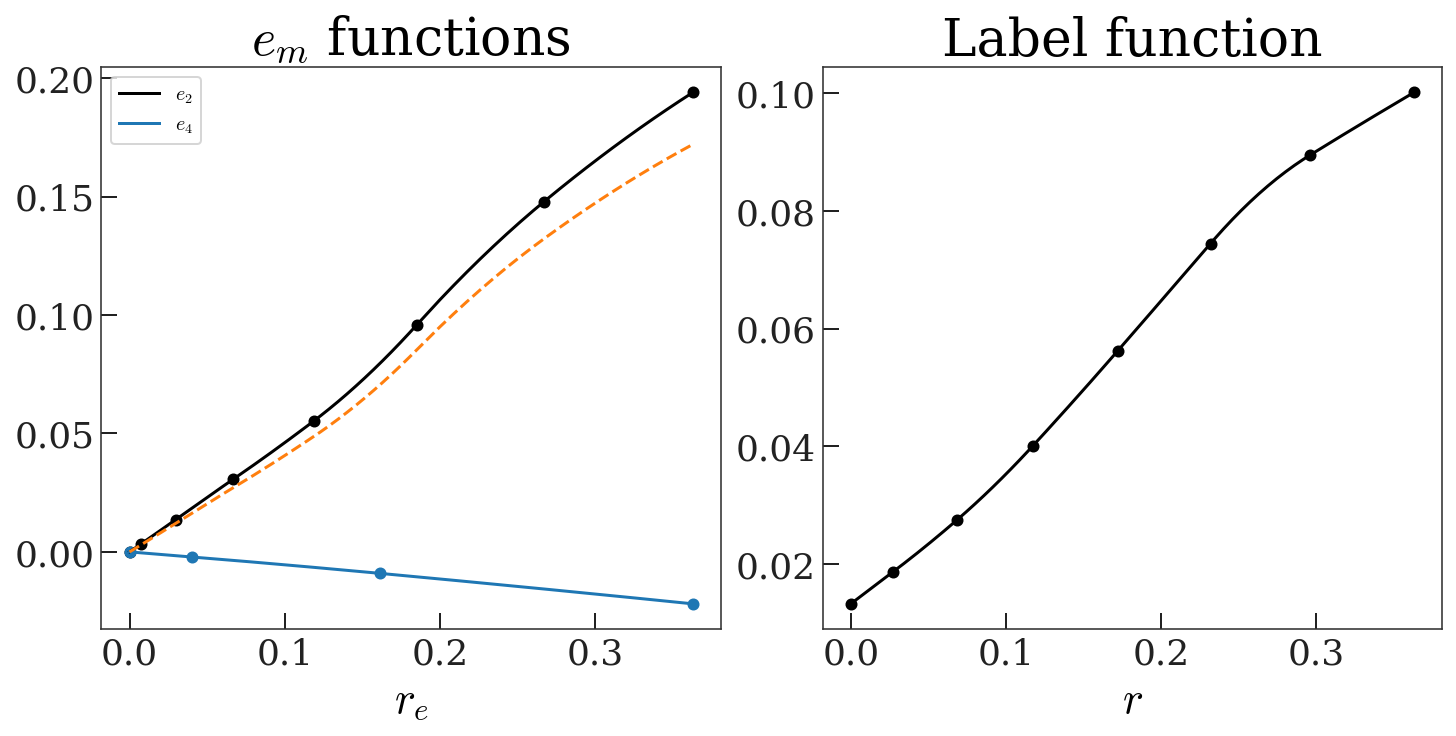

In [25]:
# _ = plot_spline_functions(model, res_params)
_ = plot_spline_functions(model, MAP_params)

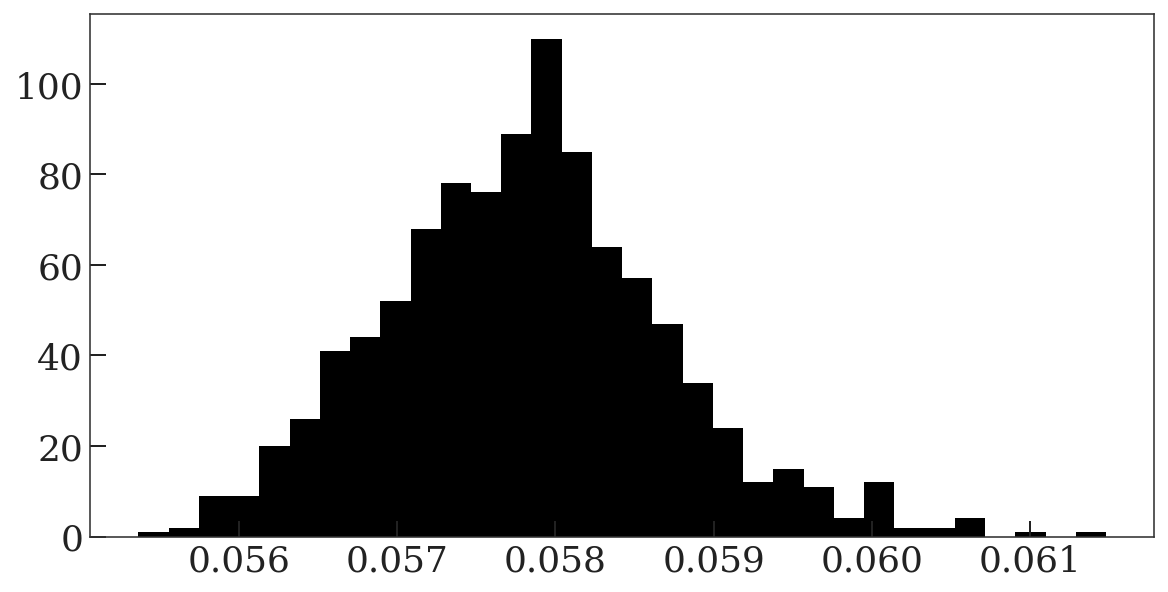

In [26]:
fig, ax = plt.subplots(figsize=(8, 4), layout="constrained")
_ = ax.hist(np.exp(mcmc_states.position["ln_Omega0"]), bins=32)
# ax.axvline(true_Omega, color="tab:green")

In [27]:
accs = []
zgrid = np.linspace(-1, 1, 512) * max_z
for p in mcmc_params:
    acc = model.get_acceleration(zgrid, p)
    accs.append(acc.value)
accs = accs * acc.unit

In [28]:
a_unit = u.km / u.s / u.Myr
bestfit_acc = model.get_acceleration(zgrid, res_params).to(a_unit)
MAP_acc = model.get_acceleration(zgrid, MAP_params).to(a_unit)

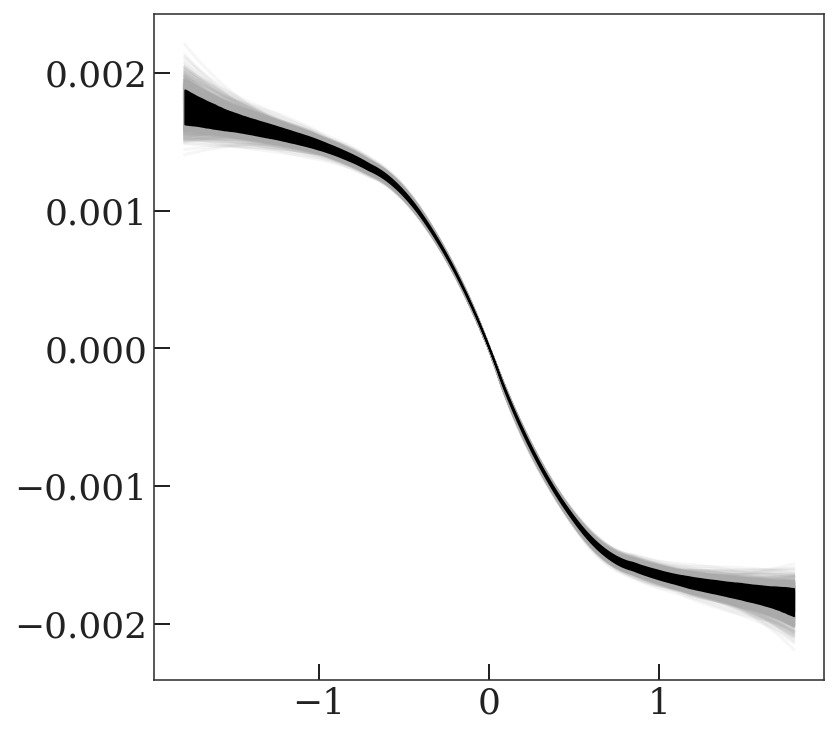

In [29]:
plt.plot(zgrid, accs.T, marker="", alpha=0.1, color="#aaaaaa")

p1, p2 = np.nanpercentile(accs.value, [16, 84], axis=0)
plt.fill_between(zgrid.value, p1, p2, color="k", zorder=10)

In [8]:
with open("/mnt/home/jhunt/ceph/Bonsai/r2/B2/AdrianAccel702.p", "rb") as f:
    rrt, zzt, ppt, accelt = pickle.load(f)

grid_r_mask = (rrt == 8.0) & np.isclose(ppt, ppt[np.argmin(np.abs(ppt - np.pi))])

In [46]:
from scipy.interpolate import InterpolatedUnivariateSpline

# shit = InterpolatedUnivariateSpline(zzt[grid_r_mask], accelt[grid_r_mask, 2])
# fuck = InterpolatedUnivariateSpline(zgrid.value, MAP_acc.to_value(a_unit))
# eval_r = 0.4
# norm = np.mean([shit(eval_r) / fuck(eval_r), shit(-eval_r) / fuck(-eval_r)])
# print(norm)

norm = (1.0 * u.cm / u.s**2).to_value(u.km / u.s / u.Myr) / 1.5
true_zz_grid = zzt[grid_r_mask]
true_acc_grid = accelt[grid_r_mask, 2] / norm

true_acc_interp = InterpolatedUnivariateSpline(true_zz_grid, true_acc_grid)
true_acc = true_acc_interp(zgrid.value + MAP_params["pos0"]) * MAP_acc.unit

In [47]:
daccs = accs.T - true_acc[:, None]

In [44]:
subset_N = 100_000
aaf = model.compute_action_angle(
    pdata["z"][:subset_N], pdata["v_z"][:subset_N], MAP_params
)

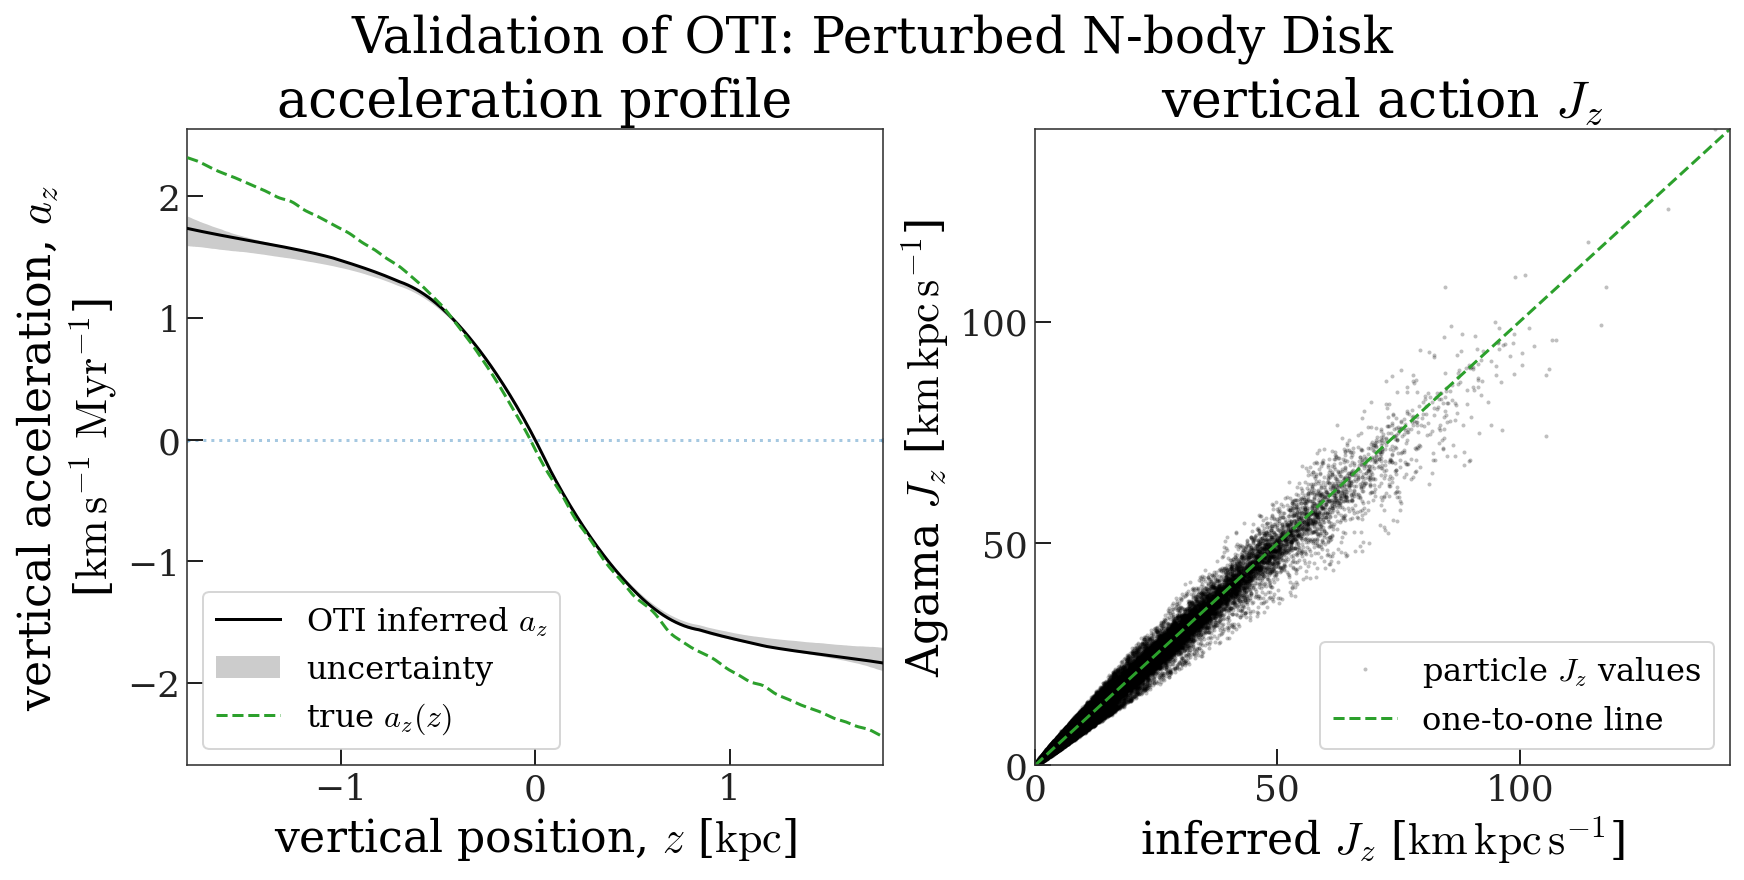

In [48]:
fig, axes = plot_az_Jz(
    MAP_acc,
    accs,
    zgrid,
    aaf,
    true_acc,
    pdata["J"][:subset_N, 2] * u.km / u.s * u.kpc,
)
axes[1].set_ylabel(f"Agama $J_z$ [{u.km/u.s*u.kpc:latex_inline}]")
fig.suptitle(f"Validation of OTI: {title}", fontsize=25)

fig.savefig(
    f"../tex/figures/{name}-validation.pdf",
    dpi=250,
    pad_inches=0.1,
    bbox_inches="tight",
)

In [49]:
idx = np.abs(zgrid - 1.0 * u.kpc).argmin()
frac_dacc = (daccs / true_acc[:, None]).decompose()
np.median(frac_dacc[idx]), np.std(frac_dacc[idx]), np.diff(
    np.nanpercentile(frac_dacc[idx], [16, 84])
) / 2

(<Quantity -0.14919315>, <Quantity 0.01554574>, <Quantity [0.0159353]>)

In [50]:
frac_diff = (aaf["J"].to_value(u.km / u.s * u.kpc) - pdata["J"][:subset_N, 2]) / pdata[
    "J"
][:subset_N, 2]
np.median(frac_diff), 1.5 * MAD(frac_diff)

(0.0013404304840777823, 0.06387146671603718)

(-0.016935634605139784, 0.12265807840215408)

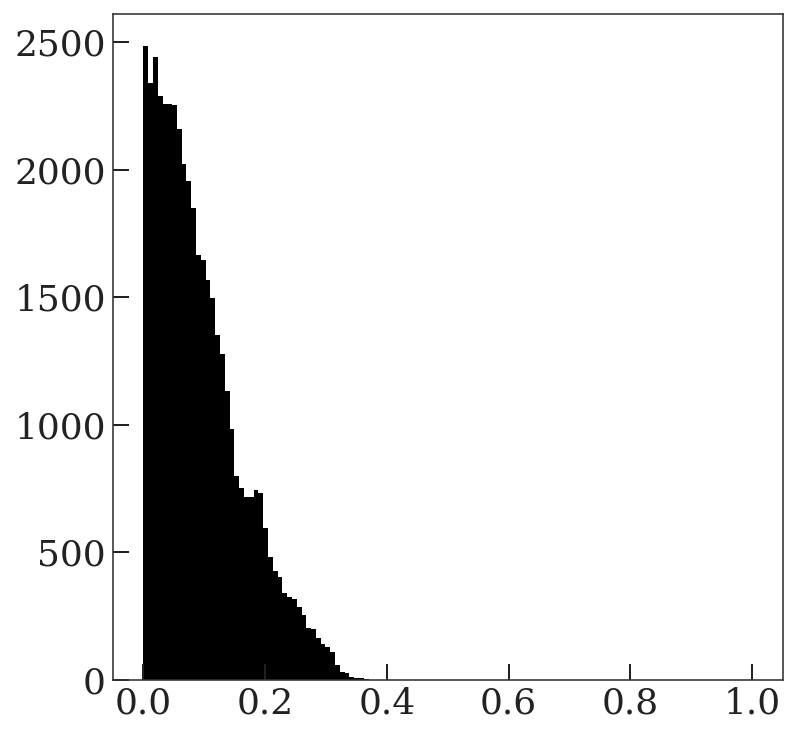

In [54]:
frac_diff = (
    aaf["Omega"].to_value(u.rad / u.Gyr) - pdata["Omega"][:subset_N, 2]
) / pdata["Omega"][:subset_N, 2]
_ = plt.hist(frac_diff, bins=np.linspace(0, 1, 128))
np.median(frac_diff), 1.5 * MAD(frac_diff)

In [16]:
frac_diff = (np.cos(aaf["theta"]) - np.cos(pdata["theta"][:subset_N, 2])) / np.cos(
    pdata["theta"][:subset_N, 2]
)
np.median(frac_diff), 1.5 * MAD(frac_diff)

(<Quantity 0.00160595>, <Quantity 0.05187178>)

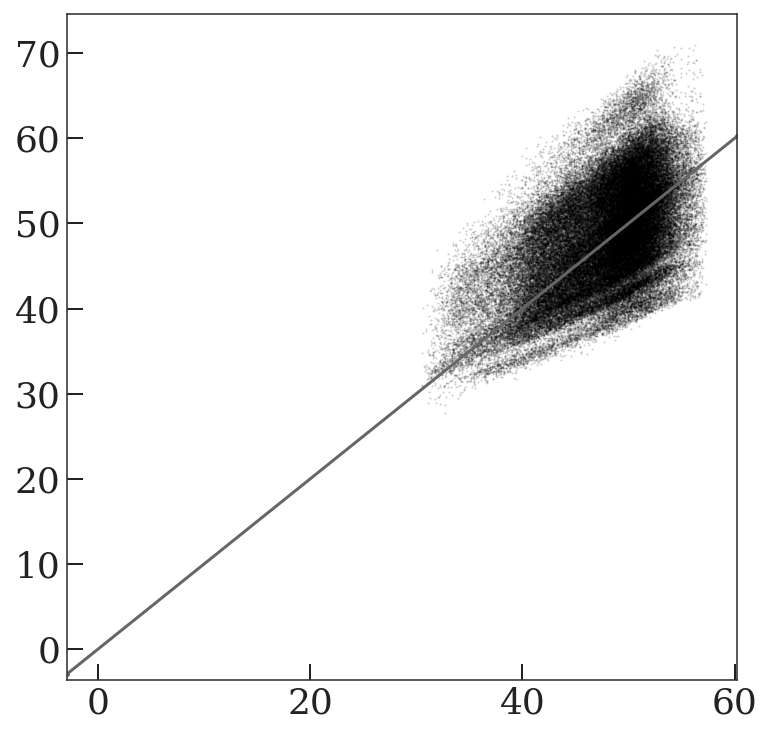

In [52]:
plt.plot(
    aaf["Omega"].to_value(u.rad / u.Gyr),
    pdata["Omega"][:subset_N, 2],
    marker="o",
    ms=1,
    ls="none",
    alpha=0.2,
)
plt.axline([0, 0], slope=1)

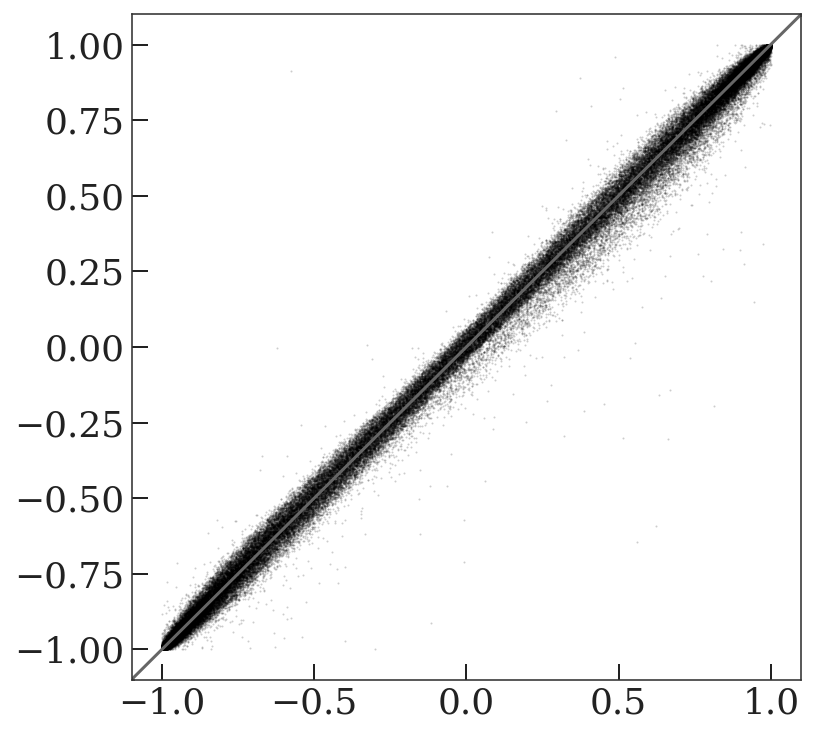

In [79]:
plt.plot(
    np.cos(aaf["theta"].to_value(u.rad)),
    np.cos(pdata["theta"][:subset_N, 2]),
    marker="o",
    ms=1,
    ls="none",
    alpha=0.2,
)
plt.axline([0, 0], slope=1)